In [1]:
%matplotlib inline

import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from pandas.plotting import scatter_matrix

plt.style.use('bmh')

**Hard**

All practice problems to follow use the same data. Pull out the old `Howell !Kung [Howell1]` demography
data and split it into two equally sized data frames.

In [2]:
data = pd.read_csv('data/Howell1.csv', sep=';')
data = data.assign(age = (data.age - data.age.mean()) / data.age.std() )
data = data[['height', 'age']]
d1 = data.sample(frac=.5, random_state=100)
d2 = data.drop(d1.index).reset_index(drop=True)
d1 = d1.reset_index(drop=True)

You now have two randomly formed data frames, each with 272 rows. The notion here is to use the cases in `d1` to fit models and the cases in `d2` to evaluate them. Now let `hi` and `xi` be the height and centered age values, respectively, on row `i`. Fit the following models to the data in `d1`:

```

    M1
    hi ∼ Normal(μi , σ)
    μi = α + β1 xi

    M2
    hi ∼ Normal(μi , σ)
    μi = α + β1 xi + β2 xi^2

    M3
    hi ∼ Normal(μi , σ)
    μi = α + β1 xi + β2 xi^2 + β3 xi^3

    M4
    hi ∼ Normal(μi , σ)
    μi = α + β1 xi + β2 xi^2 + β3 xi^3 + β4 xi^4

    M5
    hi ∼ Normal(μi , σ)
    μi = α + β1 xi + β2 xi^2 + β3 xi^3 + β4 xi^4 + β5 xi^5

    M6
    hi ∼ Normal(μi , σ)
    μi = α + β1 xi + β2 xi^2 + β3 xi^3 + β4 xi^4 + β5 xi^5 + β6 xi^6
```

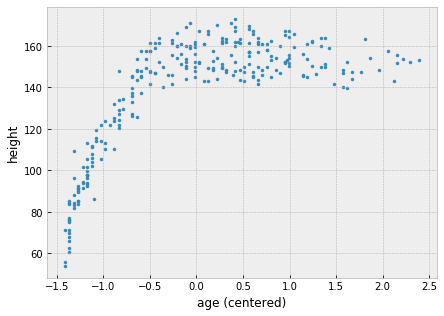

In [3]:
plt.figure(figsize=(7, 5))
plt.scatter(d1.age, d1.height, marker='.')
plt.gca().set(xlabel='age (centered)', ylabel='height')
None

In [21]:
traces = {}

for N in [1, 2, 3, 4, 5, 6]:

    with pm.Model() as model:
        alpha = pm.Normal('alpha', mu=d1.height.mean(), sd=10)
        beta = pm.Normal('beta', mu=0, sd=200, shape=N)
        
        _mu = alpha
        _mu_pred = alpha

        for i in range(N):
            _mu = _mu + beta[i] * np.power(d1.age, i+1)
            _mu_pred = _mu_pred + beta[i] * np.power(d2.age, i+1)

        mu = pm.Deterministic('mu', _mu)
        sigma = pm.HalfCauchy('sigma', beta=10)
        height = pm.Normal('height', mu=mu, sd=sigma, observed=d1.height)

        mu_pred = pm.Deterministic('mu_pred', _mu_pred)

        trace = pm.sample(5000, tune=1000, chains=2, cores=2)

    model.name = f'M{N}'
    traces[model] = trace


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:36<00:00, 326.68draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 12000/12000 [01:42<00:00, 116.89draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 12000/12000 [04:00<00:00, 29.05draws/s]


**6H1** Compare the models above, using WAIC. Compare the model rankings, as well as the WAIC weights.


In [22]:
pm.compare(traces)

/home/petrushev/etc/jup_env/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
M4,1898.91,5.27,0,0.98,21.85,0,1
M5,1900.33,6.04,1.42,0,22,1.17,1
M6,1901.19,7.26,2.28,0,21.93,2.59,1
M3,1917.86,4.72,18.95,0,21.31,8.67,0
M2,2112.33,5.35,213.42,0.02,22.58,25.94,1
M1,2391.74,3.37,492.83,0,20.9,28.45,0


**6H2** For each model, produce a plot with model averaged mean and 97% confidence interval of the mean, superimposed on the raw data. How do predictions differ across models?


In [23]:
summaries = {}

for model, trace in traces.items():
    mu_summary = pd.merge(
        pm.summary(trace, varnames=['mu'], alpha=(1-.97))
            [['mean', 'hpd_1.5', 'hpd_98.5']]
            .reset_index(drop=True),
        d1[['age', 'height']],
        how='inner', left_index=True, right_index=True)

    mu_summary = mu_summary.sort_values('age')
    summaries[model.name] = mu_summary

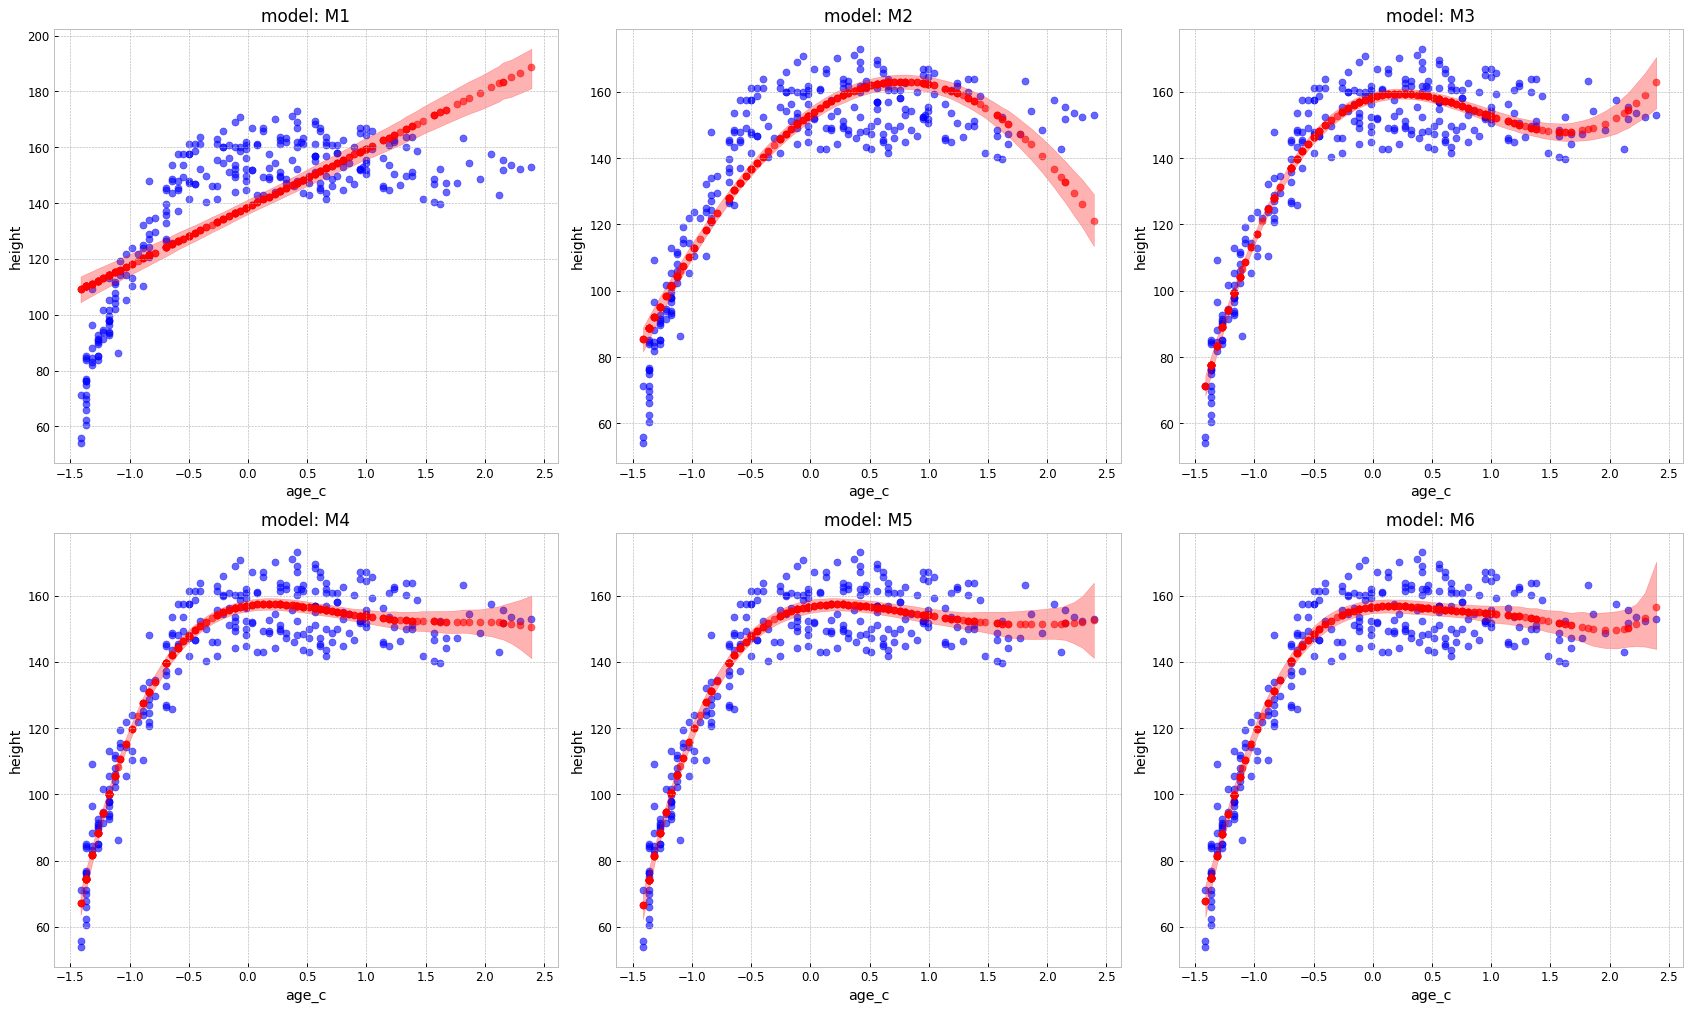

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12), dpi=85)

axes = axes.reshape(-1)

for ax, (model_name, summary) in zip(axes, summaries.items()):
    
    ax.scatter(summary.age, summary.height, color='b', alpha=.6)
    ax.scatter(summary.age, summary['mean'], color='r', alpha=.6)
    
    ax.fill_between(summary.age, summary['hpd_1.5'], summary['hpd_98.5'],
                    color='r', alpha=.3)
    
    ax.set(title=model_name, xlabel='age_c', ylabel='height',
           facecolor='w')

fig.tight_layout()
None
    

**6H3** Now also plot the model averaged predictions, across all models. In what ways do the averaged predictions differ from the predictions of the model with the lowest WAIC value?


In [25]:
pred_summaries = {}

for model, trace in traces.items():
    mu_pred_summary = pd.merge(
        pm.summary(trace, varnames=['mu_pred'], alpha=(1-.97))
            [['mean', 'hpd_1.5', 'hpd_98.5']]
            .reset_index(drop=True),
        d2[['age', 'height']],
        how='inner', left_index=True, right_index=True)

    mu_pred_summary = mu_pred_summary.sort_values('age')
    pred_summaries[model.name] = mu_pred_summary

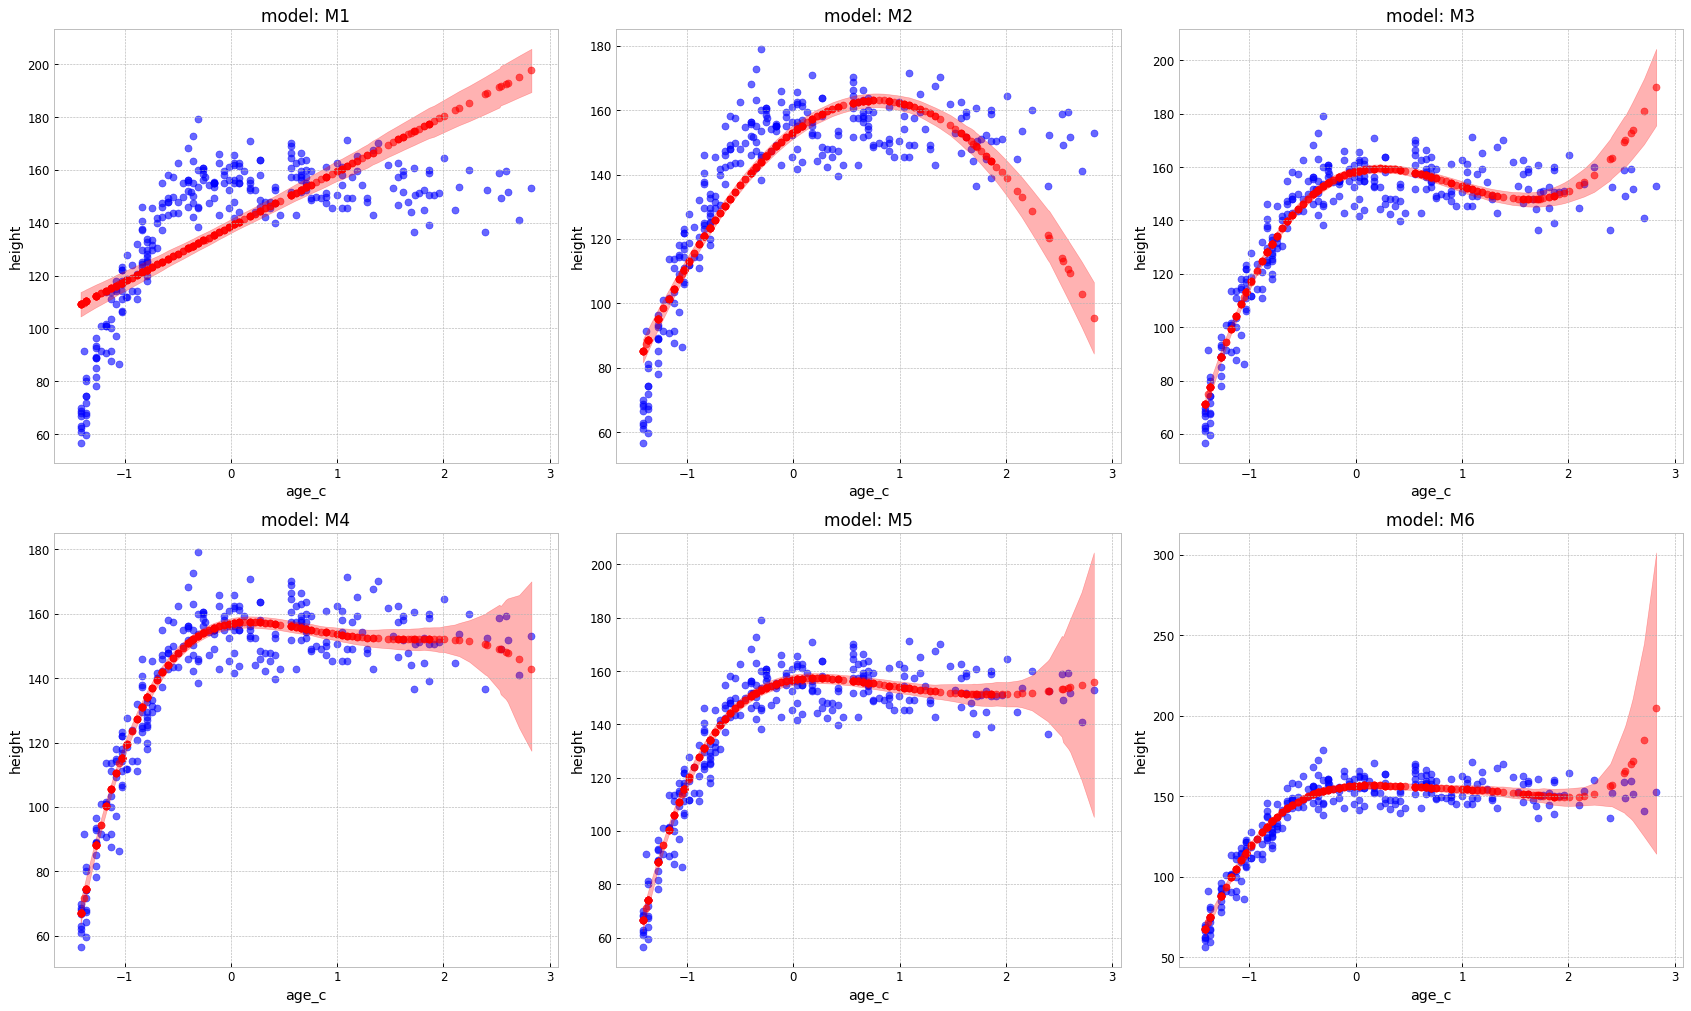

In [26]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12), dpi=85)

axes = axes.reshape(-1)

for ax, (model_name, summary) in zip(axes, pred_summaries.items()):
    
    ax.scatter(summary.age, summary.height, color='b', alpha=.6)
    ax.scatter(summary.age, summary['mean'], color='r', alpha=.6)
    
    ax.fill_between(summary.age, summary['hpd_1.5'], summary['hpd_98.5'],
                    color='r', alpha=.3)
    
    ax.set(title=f'model: {model_name}', xlabel='age_c', ylabel='height',
           facecolor='w')

fig.tight_layout()
None
    